## scoreCT: Automated cell type annotation in scRNA-seq data
ScoreCT is a script allowing automated annotation of scRNA-seq data analyzed with Scanpy. Providing your own reference or using the reference regularly updated and provided with the package, you can automatically assign clusters from your Scanpy analysis pipeline to cell types.

http://colab.research.google.com/github/blob/LucasESBS/scoreCT/tree/master/example/tuto_scoreCT.ipynb

## Option 1: Using your own reference (CSV, TSV ...)
Here, the user provide it's own csv as a reference. The wrangling and formating is left to the user as the reference table can take many different shapes. For an example, you can look at the file __ref_marker.csv__ used in this example.

In [1]:
# Import modules
import os
import sys
import pandas as pd
import scanpy.api as sc

sys.path.append('../src/')
import scorect as ct

# Load example scRNA-seq data (already analyzed)
adata = sc.read('../data/data.h5ad')

# Load reference table - the wrangling depends on your formating. For reading csv, tsv...
# Read Pandas documentation https://pandas.pydata.org/pandas-docs/stable/index.html
ref_marker = pd.read_csv('../data/ref_marker.csv', index_col=0, header=None).T

/Users/lucas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [2]:
# Wrangle results from existing sc.tl.rank_genes_groups() results
marker_df = ct.wrangle_ranked_genes(adata)
print(marker_df.head())

Number of markers used in ranked_gene_groups:  100
     z_score      adj_pvals        gene  cluster_number
0  43.342510  3.071254e-232       MGST1               0
1  37.299587  1.603663e-192        PRTG               0
2  34.916588  5.225948e-183       NR2F1               0
3  29.018284  5.412440e-137       SFRP2               0
4  28.860355  4.856073e-136  AC018730.1               0


In [3]:
# Score cell types for each cluster
dict_scores = ct.score_clusters(marker_df, nb_marker=100, bin_size=20, user_ref=ref_marker)
# Print a summary of scoring (optional)
ct.scoring_summary(dict_scores)

Rows: Cell types / Columns: Clusters


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Astrocytes,0,0,0,0,0,0,2,0,0,0,0,0,0,0,4,0,0,2
Cajal-Retzius Neurons,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,3,0
Glial-Restricted Progenitors,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
Intermediate Progenitor Cells,0,4,0,2,0,0,0,0,5,0,0,0,0,0,0,0,0,0
Neural stem cells,5,5,0,4,0,0,0,0,2,5,0,0,4,5,6,0,0,2
Neuroepithelium,10,0,0,0,0,0,9,0,0,0,0,5,0,0,6,0,0,9
Neuron Progenitors,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,7,0
Neurons,0,0,0,0,0,0,0,0,12,0,0,0,4,0,5,0,13,0
Oligodendrocytes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Radial Glia Cells,5,16,5,20,9,0,0,20,4,15,16,0,9,7,10,0,0,2


... storing 'Assigned type' as categorical


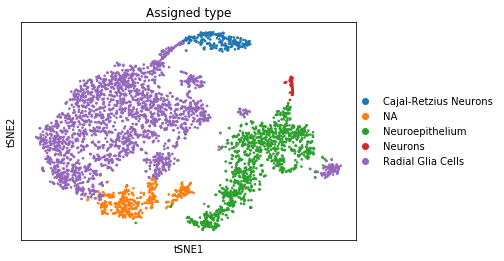

In [4]:
# Assign cell types if possible : ties are labelled as NA
ct.assign_celltypes(adata, dict_scores)
# Visualize results thanks to Scanpy tSNE tool
sc.pl.tsne(adata, color='Assigned type')

## Option 2: Use large reference files (WIP)
Here, the user has to specify the path where the large reference file is (described in the README). These files are TSV files organized and labeled by species (_eg: human.tsv_), with various features like organ and context. Right now, only one field is supported for each arguments (in the future, we would like to be able to mix several organs and contexts). The big reference file is automatically parsed to keep relevant genes/cell types to your data. </br>

The rest of the procedure is similar to Option 1.

In [5]:
# Using provided template: large reference (only template at the time)
# Load example data again
adata2 = sc.read('../data/data.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
# Wrangle results from existing sc.tl.rank_genes_groups() results
marker_df = ct.wrangle_ranked_genes(adata)
print(marker_df.head())

Number of markers used in ranked_gene_groups:  100
     z_score      adj_pvals        gene  cluster_number
0  43.342510  3.071254e-232       MGST1               0
1  37.299587  1.603663e-192        PRTG               0
2  34.916588  5.225948e-183       NR2F1               0
3  29.018284  5.412440e-137       SFRP2               0
4  28.860355  4.856073e-136  AC018730.1               0


In [7]:
# Score cell types for each cluster
# If context is None, default context is set to 'healthy'
dict_scores = ct.score_clusters(marker_df, nb_marker=100, path='../data/',
                                species='human', organ='brain', context=None,
                                comments=False, bin_size=20)
# Print a summary of scoring
ct.scoring_summary(dict_scores)

Rows: Cell types / Columns: Clusters


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Cajal-Retzius Neurons,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,3,0
Dopaminergic Neurons,0,0,0,0,0,0,0,0,8,0,0,0,4,0,5,0,10,0
GABAergic Neurons,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,10,0
Glial-Restricted Cells,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
Glutamatergic Neurons,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,13,0
Intermediate Progenitor Cells,0,4,0,2,0,0,0,0,5,0,0,0,0,0,0,0,0,0
Motor Neuron Progenitors,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Motor Neurons,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Neural stem cells,5,5,0,4,0,0,0,0,2,5,0,0,4,5,6,0,0,2
Neuroepithelium,10,0,0,0,0,0,9,0,0,0,0,5,0,0,6,0,0,9


... storing 'Assigned type' as categorical


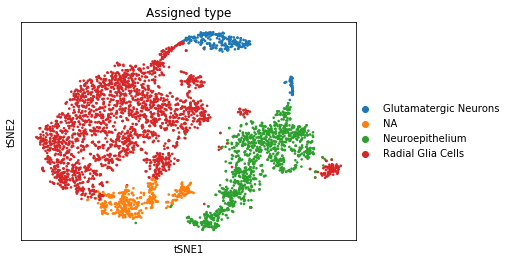

In [8]:
# Assign cell types if possible : ties are labelled as NA
ct.assign_celltypes(adata2, dict_scores)
# Visualize results thanks to Scanpy tSNE tool
sc.pl.tsne(adata2, color='Assigned type')

## Option 3: Using the cell marker database from Zhang et al., 2019 
Download file from http://biocc.hrbmu.edu.cn/CellMarker/index.jsp and uses it to score cell types. It uses their annotation and information for specified organism and tissue.

Paper: https://academic.oup.com/nar/article/47/D1/D721/5115823

In [10]:
# Load example data again
adata3 = sc.read('../data/data.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [11]:
# Wrangle results from existing sc.tl.rank_genes_groups() results
marker_df = ct.wrangle_ranked_genes(adata)
print(marker_df.head())

Number of markers used in ranked_gene_groups:  100
     z_score      adj_pvals        gene  cluster_number
0  43.342510  3.071254e-232       MGST1               0
1  37.299587  1.603663e-192        PRTG               0
2  34.916588  5.225948e-183       NR2F1               0
3  29.018284  5.412440e-137       SFRP2               0
4  28.860355  4.856073e-136  AC018730.1               0


In [12]:
# Make reference dataframe (WIP)
ref_df = ct.use_cellmarkerdb(species='Human', tissue='Brain')
ref_df.head()

,Oligodendrocyte,Cancer stem cell,Neural progenitor cell,Neutrophil,T cell,B cell,Neural stem cell,Macrophage,Microglial cell,Cancer stem-like cell,...,Lake et al.Science.Ex7,Lake et al.Science.Ex8,Lake et al.Science.In1,Lake et al.Science.In2,Lake et al.Science.In3,Lake et al.Science.In4,Lake et al.Science.In5,Lake et al.Science.In6,Lake et al.Science.In7,Lake et al.Science.In8
0,RTN4,PROM1,NGFR,MPO,,MS4A1,SOX1,CD68,CD68,FUT4,...,CHST8,ADRA2A,CNR1,CCDC141,AHRR,ADAMTS2,FREM2,LRRC38,AOX1,NMU
1,OLIG2,CADM1,GFAP,NaN,CD3D,NaN,SOX2,CD68,BCL2A1,CDH5,...,PRRX1,ANKRD13A,SDK2,GPR149,CRIM1,FREM1,HCRTR2,PVALB,COL24A1,NaN
2,ACAT2,CLCC1,NA,NaN,CD3E,NaN,SOX9,AIF1,CCL2,NaN,...,SNTG2,ATP10A,NaN,PPP1R1C,EMID1,KIT,MYB,RPH3AL,DSP,NaN
3,ACTG1,HMOX1,NGFR,NaN,CD3G,NaN,PROM1,ARG2,CCL4,NaN,...,NaN,ATP8B1,NaN,SLC7A11,EXPH5,MYH11,PDGFD,ZNF703,HPGD,NaN
4,AFAP1L2,SCAMP3,SLITRK6,NaN,,NaN,NA,BHLHE40,CD14,NaN,...,NaN,B3GAT2,NaN,NaN,IGFBP5,PDGFRA,TMEM255A,NaN,PLD1,NaN


In [15]:
# Score cell types for each cluster
dict_scores = ct.score_clusters(marker_df, nb_marker=100, bin_size=20, user_ref=ref_df)

... storing 'Assigned type' as categorical


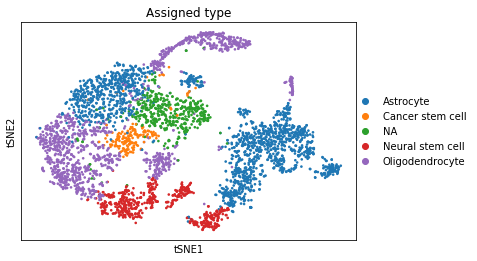

In [14]:
# Assign cell types if possible : ties are labelled as NA
ct.assign_celltypes(adata2, dict_scores)
# Visualize results thanks to Scanpy tSNE tool
sc.pl.tsne(adata2, color='Assigned type')